In [1]:
from glio.imports import *
from glio.importsglio import *
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.datasets.BRaTS2024_preloaded import get_ds_2d, get_ds_around, loader_2d, loader_around, loader_around_fix

from glio.specific.brats import plot_preds

from monai.losses.dice import DiceLoss, DiceFocalLoss, GeneralizedDiceFocalLoss
from stuff.found.torch.loss.focal_tversky_loss import focal_tversky

from schedulefree import AdamWScheduleFree
from came_pytorch import CAME
from madgrad import MADGRAD


d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
TITLE = "BRATS2024 2D general overnight3"
bratstrain = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\train hist.joblib")
bratstest = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\test hist.joblib")

dstrain = DSToTarget()
dstest = DSToTarget()
dstrain.add_samples(bratstrain, loader_around_fix, None, get0, get1)
dstest.add_samples(bratstest, loader_around_fix, None, get0, get1)

In [3]:
show_slices(dstrain[0][0])

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=5, description='s0', max=11)…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

In [4]:
from monai.networks.nets.segresnet_ds import SegResNetDS # type:ignore
print(f"{count_parameters(SegResNetDS(2, 32, 12, 4)) = }")
summary(SegResNetDS(2, 32, 12, 4), (8, 12, 96,96))

count_parameters(SegResNetDS(2, 32, 12, 4)) = 6645764
path                                         module                                       input size               output size              params    buffers   
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/conv_inittorch.nn.modules.conv.Conv2d                 (8, 12, 96, 96)          (8, 32, 96, 96)          3456      0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/norm1torch.nn.modules.batchnorm.BatchNorm2d       (8, 32, 96, 96)          (8, 32, 96, 96)          64        65        
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/act1torch.nn.modules.activation.ReLU             (8, 32, 96, 96)          (8, 32, 96, 96)          0         0         
monai.networks.nets.segresnet_ds.SegResNetDS/encoder/layers/0/blocks/0/conv1torch.nn.modules.conv.Conv2d                 (8, 32, 96, 96)          (8, 32, 96, 96)          9216      0         
monai.networks.nets.segresnet_ds

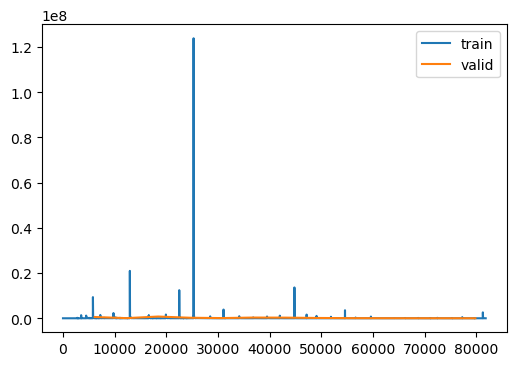

Keyboard interrupt, stopping the training...
update var: min: 0.0000; max: 0.0002; last: 0.0000
update angle: min: 0.0000; max: 0.2555; last: 0.0000
grad std: min: 0.0167; max: 25.4312; last: 0.1110
grad-update mean: min: 0.0078; max: 23.2072; last: 0.0522
grad-update angle: min: 1.1136; max: 1.9112; last: 1.5704
param mean: min: -0.0564; max: 0.0022; last: -0.0561
param var: min: 0.0007; max: 6.1798; last: 6.1798
param min: min: -25.7931; max: -0.1765; last: -25.7931
param max: min: 1.0000; max: 35.8825; last: 35.8825
time: min: 5.6642; max: 35127.1682; last: 35127.1682
lr: min: 0.0100; max: 0.0100; last: 0.0100
train loss: min: 0.2994; max: 586103232.0000; last: 4084.7031
train accuracy: min: 0.0198; max: 0.9814; last: 0.9110
train iou: min: 0.0113; max: 0.9641; last: 0.8490
train precision: min: 0.0198; max: 0.9812; last: 0.9041
train recall: min: 0.0198; max: 0.9812; last: 0.9041
train f1: min: 0.0198; max: 0.9812; last: 0.8996
train average precision: min: 0.2284; max: 0.4888; las

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


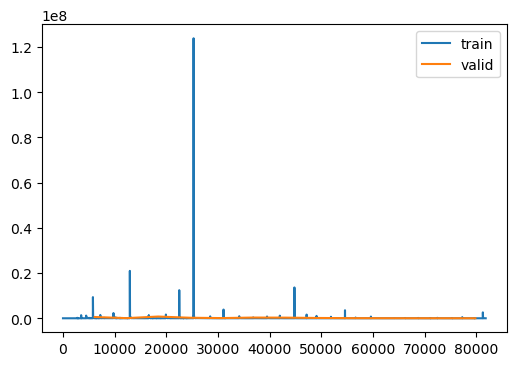

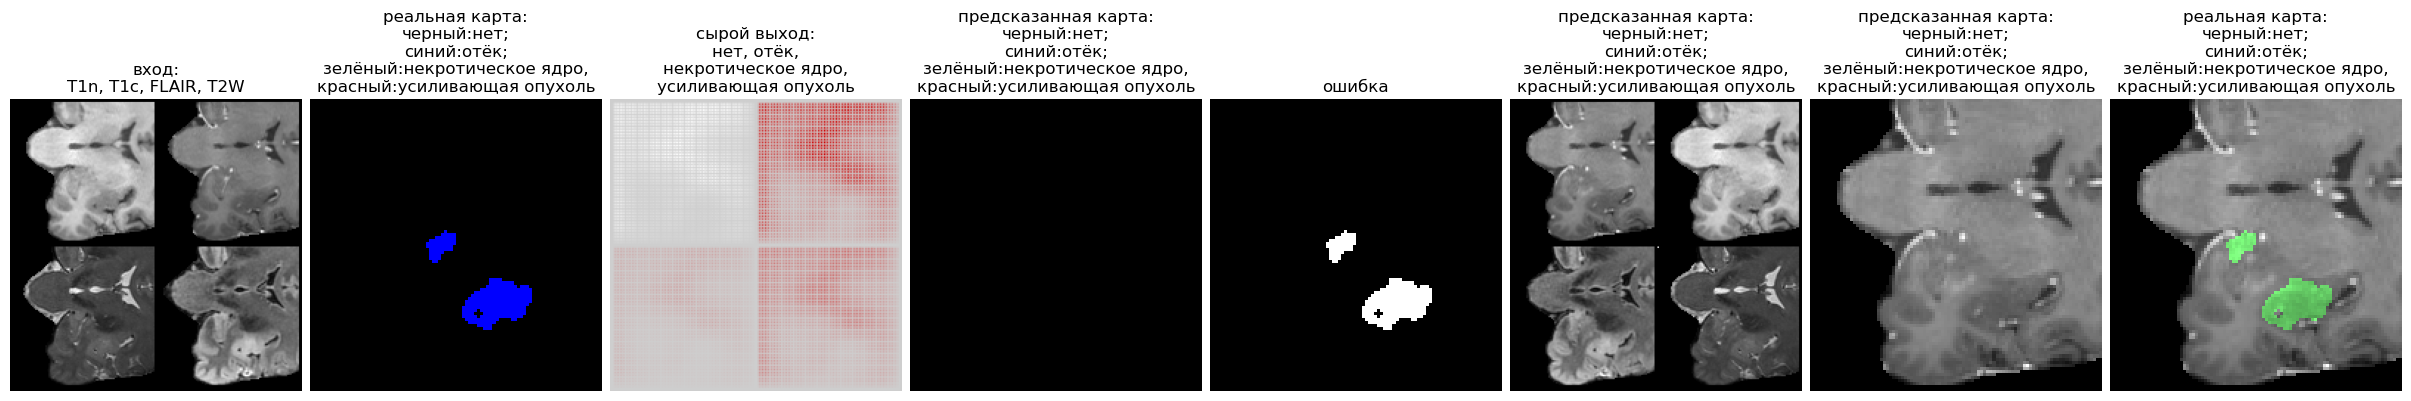

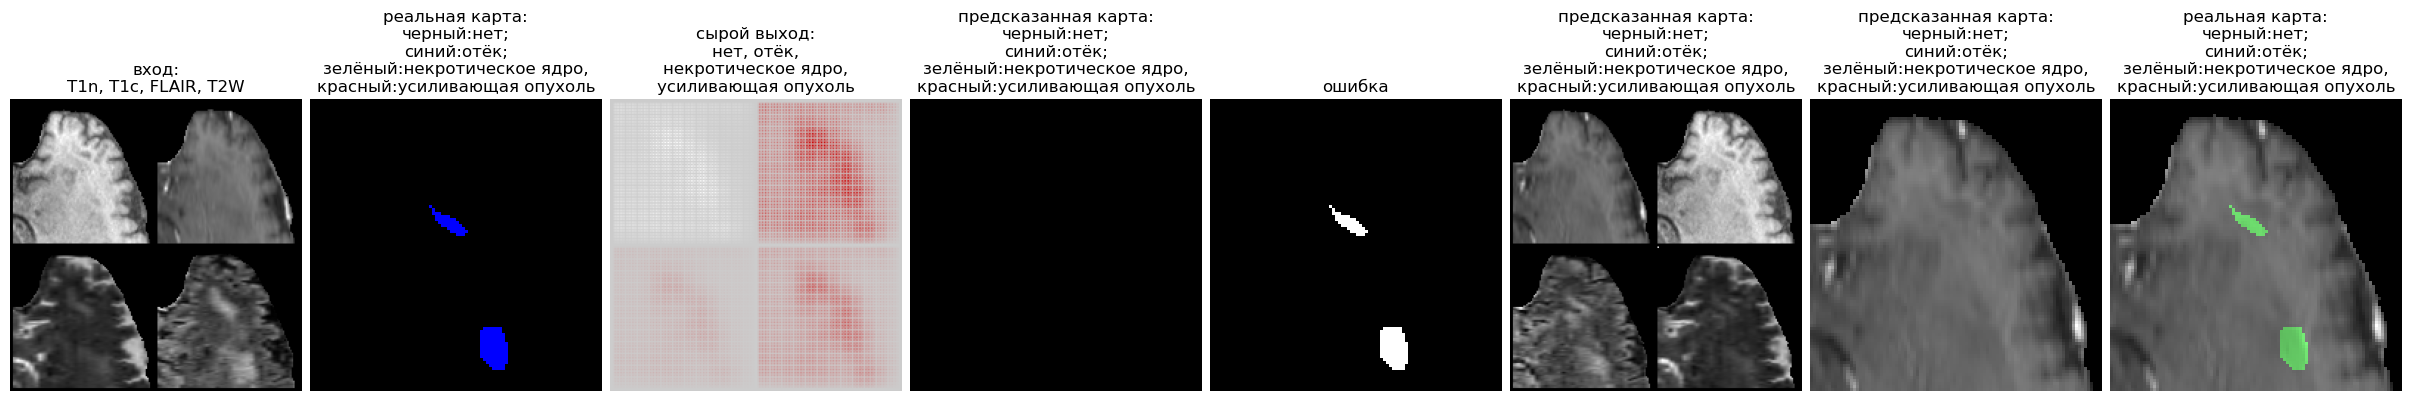

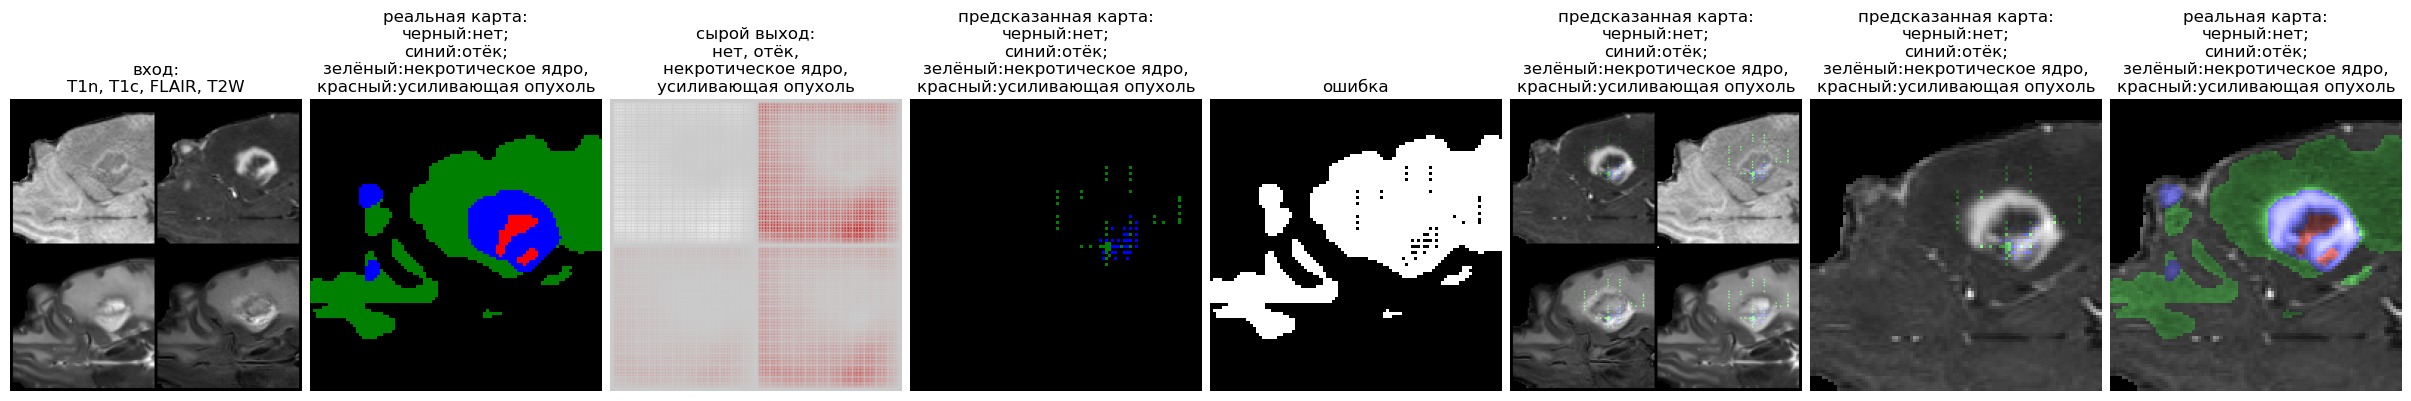

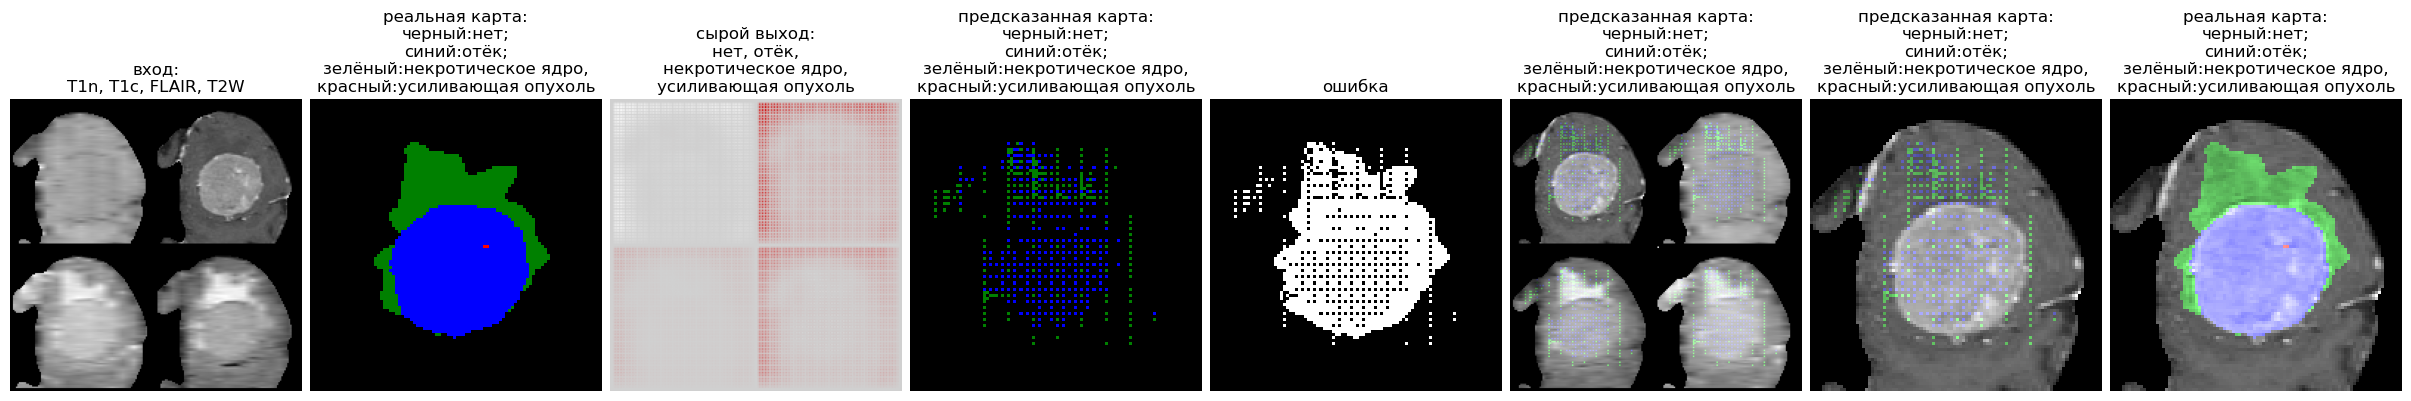

In [5]:
MODEL = SegResNetDS(2, 32, 12, 4)
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 48
N_EPOCHS = 100

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = AdamWScheduleFree(MODEL.parameters(), lr=LR, eps=1e-6, warmup_steps=1000)
LOSS_FN = DiceFocalLoss(softmax=True)
SCHED = None

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16), Log_LastGradsAngle(128), Log_GradPath(1)
              Log_UpdateDist(128), Log_GradDist(128), Log_GradUpdateAngle(128), Log_ParamDist(128),
              Log_LastUpdatesAngle(128),
              Log_ParamPath(32), Log_UpdatePath(32),
              Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), PerformanceTweaks(True), Accelerate("no"),
              Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_Precision(4, True, True, step=16),
              Torcheval_Recall(4, True, True, step=16),
              Torcheval_Dice(4, True, True, step=8, name='f1'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              FastProgressBar(step_batch=128, plot=True),
              Summary(),
              PlotSummary(),
              CallTrainAndEvalOnOptimizer(),
              )

LEARNER_NAME = f"brats-hist-around1 48 {NAME} AdamWScheduleFree1e-2 eps1e-6 DiceFocalLoss"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=False, test_on_interrupt=False)
plt.show()
plot_preds(learner, dstrain[200])
plot_preds(learner, dstest[500])
plot_preds(learner, dstrain[1650])
plot_preds(learner, dstest[1650])